In [2]:

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

shared_dir = '/Users/prateek/Desktop/ML/Major/data/'
input_shape = [32, 32]
batch = 32

training_set = image_dataset_from_directory(shared_dir,
                                            validation_split=0.2,
                                            subset="training",
                                            batch_size=batch,
                                            seed=1,
                                            color_mode='rgb',
                                            image_size=input_shape)

val_dataset = image_dataset_from_directory(shared_dir,
                                            validation_split=0.2,
                                            subset="validation",
                                            batch_size=batch,
                                            seed=1,
                                            color_mode='rgb',
                                            image_size=input_shape)

input_shape.append(3)
print(input_shape)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-21 13:19:13.408859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 13:19:13.408992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
[32, 32, 3]


In [3]:
def augment_images(x):
    x = tf.keras.layers.RandomContrast((0.1, 0.1))(x)
    x = tf.keras.layers.RandomRotation((-0.125, 0.125))(x)
    x = tf.keras.layers.RandomFlip()(x)

    return x

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras import Model, Input
from keras.applications.xception import Xception, preprocess_input
from keras.callbacks import LearningRateScheduler
import numpy as np

epochs = 100
dropout_rate = 0.2
len_classes = 5

inputs = Input(shape=input_shape)
x = augment_images(inputs) 
x = preprocess_input(x)
x = Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(8, kernel_size=(4, 4),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(4, kernel_size=(3, 3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1, activation='softmax')(x)
model = Model(inputs, outputs)
model.summary()

optimizer = tf.keras.optimizers.Adam(lr=0.01)
optimizer.learning_rate.assign(0.01)

def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 random_contrast (RandomCont  (None, 32, 32, 3)        0         
 rast)                                                           
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                               
                                                             

/Users/prateek/venv/ml/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
tf.config.set_soft_device_placement(True) 
history = model.fit(training_set, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100


/Users/prateek/venv/ml/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


InvalidArgumentError: Cannot assign a device for operation model/random_contrast/stateful_uniform_full_int/RngReadAndSkip: Could not satisfy explicit device specification '' because the node {{colocation_node model/random_contrast/stateful_uniform_full_int/RngReadAndSkip}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
RngReadAndSkip: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_random_contrast_stateful_uniform_full_int_rngreadandskip_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model/random_contrast/stateful_uniform_full_int/RngReadAndSkip (RngReadAndSkip) 

	 [[{{node model/random_contrast/stateful_uniform_full_int/RngReadAndSkip}}]] [Op:__inference_train_function_1880]

loss
binary_accuracy
val_loss
val_binary_accuracy
lr


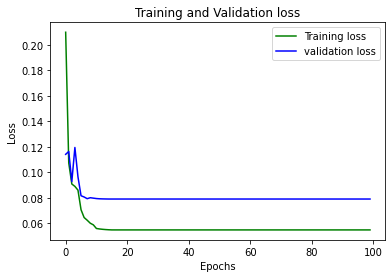

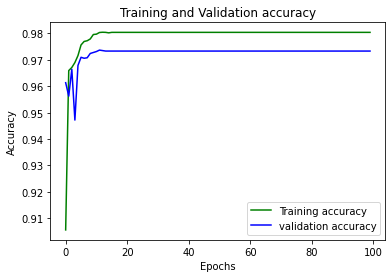

In [27]:
import matplotlib.pyplot as plt

for key in history.history.keys():
    print(key)
loss_train = history.history['loss']
loss_val = history.history['val_loss']
no_epochs = range(epochs)
plt.plot(no_epochs, loss_train, 'g', label='Training loss')
plt.plot(no_epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['binary_accuracy']
loss_val = history.history['val_binary_accuracy']
plt.plot(no_epochs, loss_train, 'g', label='Training accuracy')
plt.plot(no_epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.BinaryAccuracy())
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# rm -rf logs
%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]

NameError: name 'base_model' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# rm -rf logs
%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]
model.fit(training_set, epochs=epochs,validation_data=val_dataset,callbacks=callbacks)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15


2022-03-16 19:20:10.474866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


663/689 [===========================>..] - ETA: 2s - loss: 0.4163 - binary_accuracy: 0.7972